In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABC, abstractmethod
from typing import Literal
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
# load train data
processed_dir = Path().cwd().parent / 'data' / 'processed'
train_path = processed_dir / 'pro_train.pkl'
test_path = processed_dir / 'pro_test.pkl'

In [3]:
train_df = pd.read_pickle(train_path)

In [4]:
# make copy of data
X_train = train_df.copy()

In [5]:
def corr_significance(df: pd.DataFrame, y_var: str = "SalePrice"):
    num_cols = df.select_dtypes(include="number").columns

    def calculate_corr(col: str, i: int):
        return round(pearsonr(df[col], df[y_var])[i], 4)

    stats = [
        {
            "Variable": col,
            "correlation": calculate_corr(col, 0),
            "p-value": calculate_corr(col, 1),
            "significant": True if calculate_corr(col, 1) < 0.05 else False,
        }
        for col in num_cols
    ]
    return (
        pd.DataFrame(stats)
        .sort_values(by="correlation", ascending=False)
        .reset_index(drop=True)
    )

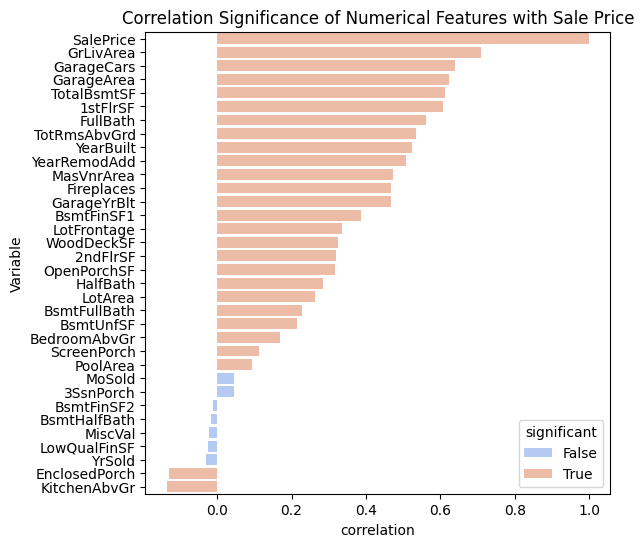

In [6]:
y_var_corr_sig = corr_significance(X_train)

plt.subplots(figsize=(6, 6))
sns.barplot(data=y_var_corr_sig, x='correlation', y='Variable', hue='significant', palette='coolwarm')
plt.title('Correlation Significance of Numerical Features with Sale Price')
plt.show()

## Mutual Information


Mutual information allows us to reduce the uncertainty of variables based on the information of other variables. If all you have available is a specific feature value, how much certainty would this give you about the value of the target variable? The mutual information score is measured on a logarithmic scale, therefore, scores over 2 are very rare given how logarithms increase slowly

In [7]:
def split_x_y_vars(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    X = df.drop(columns='SalePrice')
    y = df['SalePrice'].copy()
    
    return X, y

In [8]:
def factorize_cats(X: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes

    discrete_features = X.dtypes == int
    
    return X, discrete_features

In [9]:
def create_mi_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    X_factored, discrete_features = factorize_cats(X)
    mi_scores = mutual_info_regression(X_factored, y, discrete_features=discrete_features).round(2)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [10]:
X, y = split_x_y_vars(X_train)

mi_scores = create_mi_scores(X, y)

mi_scores.head(10)

OverallQual     0.57
GarageArea      0.50
Neighborhood    0.50
GrLivArea       0.43
YearBuilt       0.41
TotalBsmtSF     0.40
LotArea         0.39
GarageCars      0.37
BsmtQual        0.34
KitchenQual     0.33
Name: MI Scores, dtype: float64

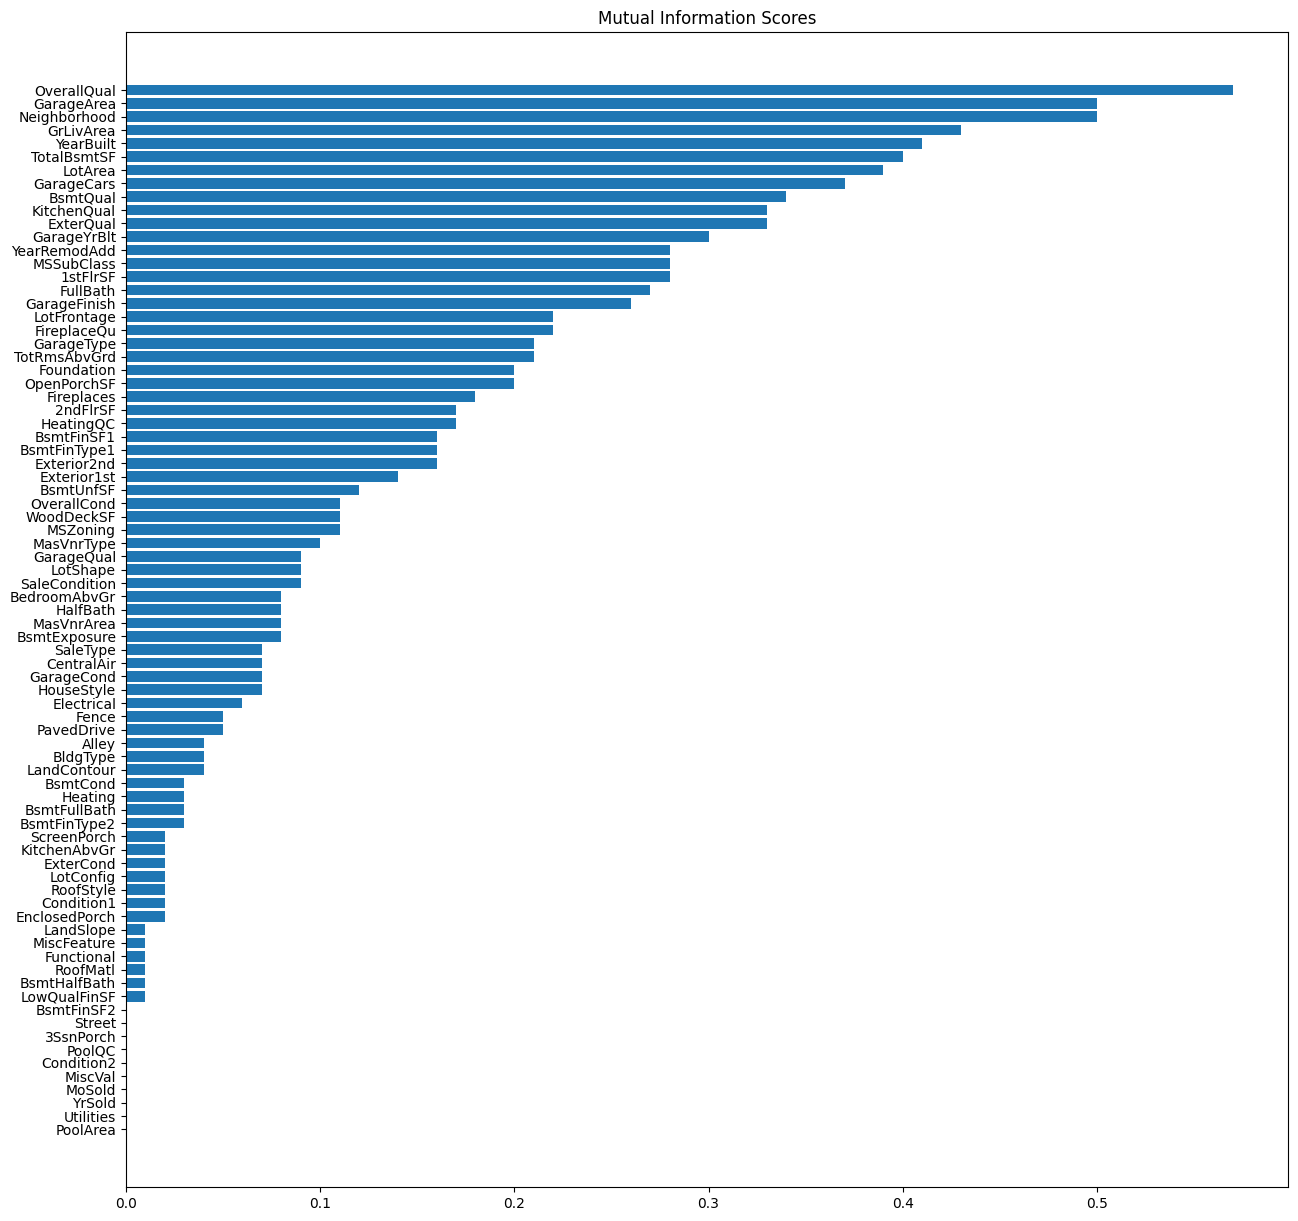

In [11]:
def plot_mi_scores(scores: pd.Series) -> None:
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(15, 15))
plot_mi_scores(mi_scores)

## Feature Pipeline Strategy

To make our code more re-producible and readable, we will follow SOLID design principles which is an object orientated approach to data processing

Feature processing base class - this is the route class from which each of our processing classes will inherit. As we will see later this is useful for chaining each processing stage together in one pipeline. By doing this it means we can call the .process() method only once when running the processing pipeline.

In [12]:
class FeatureProcessor(ABC):
    def __init__(self, features: list[str]):
        self._features = features
        
    @abstractmethod
    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        pass

## Create Baseline to score features

In [13]:
def feature_processor(df: pd.DataFrame) -> ColumnTransformer:
    num_cols = [col for col in df.select_dtypes(include="number").columns.tolist()]
    cat_cols = df.select_dtypes(include="category").columns

    cat_transformer = Pipeline(
        [
            (
                "cat",
                OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            ),
        ],
    )

    num_transformer = Pipeline(
        [
            ("scaler", RobustScaler()),
        ]
    )

    return ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_cols),
            ("cat", cat_transformer, cat_cols),
        ]
    )

In [14]:
def score_dataset(df: pd.DataFrame) -> float:
    X, y = split_x_y_vars(df)
    
    y = np.log1p(y)
    
    model = GradientBoostingRegressor(random_state=42, loss='huber')
    preprocessor = feature_processor(X)

    eval_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    score = -cross_val_score(eval_pipe, X, y, cv=kf, scoring='neg_mean_squared_error').mean()
    return np.sqrt(score)

In [15]:
# Baseline model score
score_dataset(X_train)

0.13404765690400058

In [16]:
# make copy of orig data
feature_df_1 = X_train.copy()

## Data Skewness

In [17]:
skew = feature_df_1.skew(numeric_only=True).sort_values(ascending=False)
skew.head(25)

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.677616
LotFrontage       2.409147
OpenPorchSF       2.364342
SalePrice         1.882876
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
TotRmsAbvGrd      0.676341
HalfBath          0.675897
Fireplaces        0.649565
BsmtFullBath      0.596067
dtype: float64

In [18]:
class SkewProcessor(FeatureProcessor):
    def __init__(self, features: list[str] | None = None):
        super().__init__(features)

    def _skewed_features(self, df: pd.DataFrame) -> list[str]:
        skewed = df.skew(numeric_only=True).sort_values(ascending=False)
        return skewed[skewed > 0.5].index.tolist()

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        skewed_feats = self._skewed_features(df)
        for feature in skewed_feats: 
            if feature != 'SalePrice':
                try:
                    df.loc[:, feature] = PowerTransformer(method="box-cox").fit_transform(
                        df[feature].values.reshape(-1, 1) + 1
                    )
                except ValueError:
                    print(
                        f"Feature {feature} has negative values and cannot be box-cox transformed"
                    )
                    continue
        return df

In [19]:
feature_df_1 = SkewProcessor().process(feature_df_1)

In [20]:
score_dataset(feature_df_1)

0.13523838392452453

## Principle Component Analysis    

In [21]:
# what are the most correlated features?
factor_df, _ = factorize_cats(X_train)
corr_df = factor_df.corr()['SalePrice'].sort_values(ascending=False).reset_index()
corr_df.columns = ['Feature', 'Correlation']
corr_df.head()

,Feature,Correlation
0,SalePrice,1.000000
1,OverallQual,0.790982
2,GrLivArea,0.708624
3,ExterQual,0.682639
4,KitchenQual,0.659600


In [22]:
mi_scores = create_mi_scores(X_train.drop(columns='SalePrice'), X_train['SalePrice']).reset_index()
mi_scores.columns = ['Feature', 'MI Score']
mi_scores.head()

,Feature,MI Score
0,OverallQual,0.56
1,Neighborhood,0.51
2,GarageArea,0.50
3,GrLivArea,0.43
4,YearBuilt,0.41


In [23]:
corr_mi_df = pd.merge(corr_df, mi_scores, on='Feature', suffixes=('_corr', '_mi'))
corr_mi_df['combined_scores'] = corr_mi_df['Correlation'] + corr_mi_df['MI Score']
corr_mi_df.sort_values(by='combined_scores', ascending=False).head(10)

,Feature,Correlation,MI Score,combined_scores
0,OverallQual,0.790982,0.56,1.350982
1,GrLivArea,0.708624,0.43,1.138624
5,GarageArea,0.623431,0.50,1.123431
6,TotalBsmtSF,0.613581,0.40,1.013581
4,GarageCars,0.640409,0.37,1.010409
2,ExterQual,0.682639,0.32,1.002639
3,KitchenQual,0.659600,0.31,0.969600
12,YearBuilt,0.522897,0.41,0.932897
8,BsmtQual,0.585207,0.32,0.905207
7,1stFlrSF,0.605852,0.28,0.885852


In [24]:
# four features to analyse
features = [
    'TotalBsmtSF',
    'GrLivArea',
    'ExterQual',
    'GarageArea',
]

corr_mi_df[corr_mi_df['Feature'].isin(features)]

,Feature,Correlation,MI Score,combined_scores
1,GrLivArea,0.708624,0.43,1.138624
2,ExterQual,0.682639,0.32,1.002639
5,GarageArea,0.623431,0.50,1.123431
6,TotalBsmtSF,0.613581,0.40,1.013581


Class that creates a principle component based on selected features

In [25]:
class PCAProcessor(FeatureProcessor):
    def __init__(
        self,
        features: list[str],
        n_components: int | None = None,
        standardise: bool = True,
    ):
        super().__init__(features)
        self._standardise = standardise
        self._n_components = n_components
        self._loadings = pd.DataFrame()
        self._pca = None
        self._X_pca = None

    def _initialise_pca(self) -> PCA:
        return PCA(n_components=self._n_components)
        
    def _create_loadings(self) -> pd.DataFrame:
        return pd.DataFrame(
            self._pca.components_.T,
            columns=[f"PC{i+1}" for i in range(self._X_pca.shape[1])],
            index=self._features,
        )
        
    def _X_pca_df(self, X: pd.DataFrame) -> pd.DataFrame:
        return pd.DataFrame(
            self._X_pca,
            columns=[f"PC{i+1}" for i in range(self._X_pca.shape[1])],
            index=X.index,
        )

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        X = df.loc[:, self._features]
        if self._standardise:
            X = (X - X.mean(axis=0)) / X.std(axis=0)
        
        self._pca = self._initialise_pca()
        self._X_pca = self._pca.fit_transform(X)    
        self._loadings = self._create_loadings()
        X_pca_df = self._X_pca_df(X)
        df.loc[:, 'PC1'] = X_pca_df['PC1']
        return df
    
    @property
    def pca_(self) -> PCA:
        return self._pca
    
    @property
    def loadings_(self) -> pd.DataFrame:
        return self._loadings

In [26]:
feature_df_2 = X_train.copy()

In [27]:
pca_processor = PCAProcessor(features=features)

feature_df_2 = pca_processor.process(feature_df_2)

In [28]:
pca_processor.loadings_

,PC1,PC2,PC3,PC4
TotalBsmtSF,0.501492,-0.108077,0.845796,-0.146474
GrLivArea,0.487363,0.820156,-0.219506,-0.204056
ExterQual,0.499074,-0.542518,-0.452192,-0.502117
GarageArea,0.511769,-0.146076,-0.178797,0.827518


In [29]:
pca_processor.pca_

PCA()

In [30]:
def plot_variance(pca: PCA, width: int = 8, dpi: int = 100) -> plt.Axes:
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))
    # Set up figure
    fig.set(figwidth=width, dpi=dpi)
    return axs

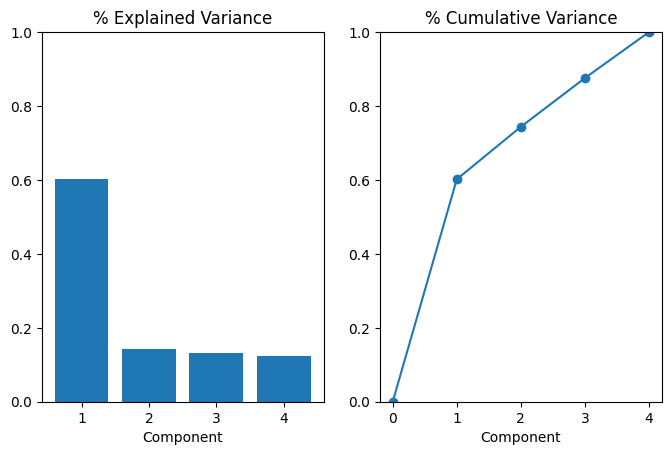

In [31]:
plot_variance(pca_processor.pca_)
plt.show()

In [32]:
create_mi_scores(feature_df_2.drop(columns=['SalePrice']), y)

PC1             0.81
OverallQual     0.57
Neighborhood    0.51
GarageArea      0.49
GrLivArea       0.43
                ... 
MiscVal         0.00
MoSold          0.00
YrSold          0.00
LandSlope       0.00
3SsnPorch       0.00
Name: MI Scores, Length: 80, dtype: float64

In [33]:
# Show dataframe sorted by PC3
idx = feature_df_2.drop(columns=['SalePrice'])["PC1"].sort_values(ascending=False).index 
feature_df_2.loc[idx, ["SalePrice", "Neighborhood", 'OverallQual'] + features]

,SalePrice,Neighborhood,OverallQual,TotalBsmtSF,GrLivArea,ExterQual,GarageArea
Id,,,,,,,
1299,160000,7,10,6110,5642,5,1418
524,184750,7,10,3138,4676,5,884
692,755000,15,10,2444,4316,5,832
1183,745000,15,10,2396,4476,4,813
582,253293,16,8,2042,2042,5,1390
...,...,...,...,...,...,...,...
376,61000,7,1,683,904,2,0
1324,82500,3,4,420,708,2,0
637,60000,3,2,264,800,2,0


In [34]:
score_dataset(feature_df_2)

0.13224199366382275

Score decreased slightly from 0.135 -> 0.132

## Clustering

KMeans - cluster based on features used for principle component analysis

Class that creates a specified number of clusters for certain variables

In [35]:
class KMeansCluster(FeatureProcessor):
    def __init__(self, features: list[str], n_clusters: int):
        super().__init__(features)
        self._n_clusters = n_clusters

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        X_feats = df[self._features].copy()
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(
            scaler.fit_transform(X_feats), columns=X_feats.columns, index=X_feats.index
        )
        kmeans = KMeans(n_clusters=self._n_clusters, random_state=42)
        X_scaled.loc[:, "cluster"] = kmeans.fit_predict(X_scaled).astype(int)
        df.loc[:, "cluster"] = X_scaled["cluster"]
        return df

In [36]:
for i in range(2, 11):
    cluster_df = KMeansCluster(features=features, n_clusters=i).process(feature_df_2)
    print(f"{i} Clusters -> RMSLE: {score_dataset(cluster_df)}")

2 Clusters -> RMSLE: 0.13234807576647703
3 Clusters -> RMSLE: 0.13229718955658237
4 Clusters -> RMSLE: 0.13220865203374377
5 Clusters -> RMSLE: 0.1315928847117627
6 Clusters -> RMSLE: 0.131679291800417
7 Clusters -> RMSLE: 0.13217617794230724
8 Clusters -> RMSLE: 0.13275509777412434
9 Clusters -> RMSLE: 0.13338969607747003
10 Clusters -> RMSLE: 0.1327753012314934


5 clusters seems to provide the best RMSLE score

In [37]:
feature_df_3 = KMeansCluster(features=features, n_clusters=5).process(feature_df_2)

The score has now come down under 0.131

## Target Encoding

Neighbourhood variable has the most categorical features (25). We can use target encoding to create values for each category that are more reflective of their relationship with the target variable in comparison with OrdinalEncoder which has to be specified manually.

Class that target encodes selected large categorical variables

In [38]:
class TargetEncoder(FeatureProcessor):
    def __init__(self, features: list[str], target: str):
        super().__init__(features)
        self._target = target
        self._encoder = None

    def _encode_target(self, df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
        # encode of 20% of data to avoid overfitting
        X_encode = df.sample(frac=0.2, random_state=42)
        target_encode = X_encode.pop(self._target)
        return X_encode, target_encode

    def _split_data(self, df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
        X_pretrain = df.drop(columns=self._target)
        target_train = df[self._target].copy()
        return X_pretrain, target_train

    def _fit_encoder(self, X: pd.DataFrame, y: pd.Series) -> None:
        encoder = MEstimateEncoder(cols=self._features, m=1, random_state=42)
        self._encoder = encoder.fit(X, y)

    def _transform_data(self, X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
        df = self._encoder.transform(X, y)
        df.loc[:, self._target] = y
        return df

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        X_encode, target_encode = self._encode_target(df)
        X_pretrain, target_train = self._split_data(df)
        self._fit_encoder(X_encode, target_encode)
        return self._transform_data(X_pretrain, target_train)

In [39]:
# get non-ordered categorical features
cols = train_df.select_dtypes(include='category').columns
features_nom = [col for col in cols if not train_df[col].cat.ordered and col in feature_df_2.columns]
features_nom

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'GarageType',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [40]:
# return category features with more than 15 unique values
mask = train_df.select_dtypes(include='category').nunique().sort_values(ascending=False)
target_features = mask[mask > 7].index.tolist()
target_features

['Neighborhood',
 'Exterior2nd',
 'Exterior1st',
 'MSSubClass',
 'OverallQual',
 'OverallCond',
 'SaleType',
 'Condition1',
 'Condition2',
 'HouseStyle',
 'RoofMatl']

In [41]:
for feat in target_features:
    if feat != 'OverallQual':
        target_df = TargetEncoder(features=[feat], target='OverallQual').process(feature_df_3)
        print(f"{feat} -> RMSLE: {score_dataset(target_df)}")

Neighborhood -> RMSLE: 0.13293595905077657
Exterior2nd -> RMSLE: 0.1318439799894606
Exterior1st -> RMSLE: 0.13179290501843285
MSSubClass -> RMSLE: 0.13253666688128277
OverallCond -> RMSLE: 0.13338713394349713
SaleType -> RMSLE: 0.13342924712662899
Condition1 -> RMSLE: 0.13194985358676808
Condition2 -> RMSLE: 0.13193467266879394
HouseStyle -> RMSLE: 0.13178491742125295
RoofMatl -> RMSLE: 0.13054622199048174


In [42]:
feature_df_4 = TargetEncoder(features=target_features, target='SalePrice').process(feature_df_3)

In [43]:
score_dataset(feature_df_4)

0.13421591143997447

## One-Hot Encode

Class that creates one hot encoded variables from selected features

In [44]:
class DummyEncoder(FeatureProcessor):
    def __init__(self, features: list[str]):
        super().__init__(features)
        self._encoder = OneHotEncoder()

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        ohe = self._encoder.fit_transform(df[self._features]).toarray()
        ohe_df = pd.DataFrame(
            ohe, columns=self._encoder.get_feature_names_out(self._features), index=df.index
        )
        df_encoded = pd.concat([df, ohe_df], axis=1)
        df_encoded = df_encoded.drop(columns=self._features)
        return df_encoded

    @property
    def encoded_columns_(self) -> list[str]:
        return self._encoder.get_feature_names_out(self._features)

During the feature process our categorical variables have been ordinal encoded so need to transform the unordered categories back to their original values

In [45]:
features_ohe = [col for col in features_nom if col not in target_features]

# map the columns to their original values
for col in features_ohe:
    d = dict(enumerate(train_df[col].cat.categories))
    feature_df_4[col] = feature_df_4[col].map(d)

# only run once - if run it twice re-run the feature_df_4 dataframe above
feature_df_4.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,PC1,cluster,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,244687.096861,RL,65.0,8450,Pave,None,1,Lvl,3,Inside,3,187384.022546,183924.975921,179879.116995,1Fam,213301.172228,213736.448575,205297.447343,2003,2003,Gable,175827.149691,216589.789705,217417.050649,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,2,5,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,Attchd,2003.0,2,2,548,3,3,3,0,61,0,0,0,0,0,0,None,0,2,2008,167944.401608,Normal,0.654734,2,208500
2,184593.143802,RL,80.0,9600,Pave,None,1,Lvl,3,FR2,3,179279.937215,147089.425728,179879.116995,1Fam,171513.578744,156740.293932,141241.100647,1976,1976,Gable,175827.149691,149953.308576,149145.176233,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,2,5,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,3,Attchd,1976.0,2,2,460,3,3,3,298,0,0,0,0,0,0,0,None,0,5,2007,167944.401608,Normal,-0.376345,3,181500
3,244687.096861,RL,68.0,11250,Pave,None,2,Lvl,3,Inside,3,187384.022546,183924.975921,179879.116995,1Fam,213301.172228,213736.448575,205297.447343,2001,2002,Gable,175827.149691,216589.789705,217417.050649,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,2,5,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,3,Attchd,2001.0,2,2,608,3,3,3,0,42,0,0,0,0,0,0,None,0,9,2008,167944.401608,Normal,0.941999,2,223500
4,140757.201294,RL,60.0,9550,Pave,None,2,Lvl,3,Corner,3,201357.976455,183924.975921,179879.116995,1Fam,213301.172228,213736.448575,205297.447343,1915,1970,Gable,175827.149691,146234.216990,169167.962329,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,2,5,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,4,Detchd,1998.0,1,3,642,3,3,3,0,35,272,0,0,0,0,0,None,0,2,2006,167944.401608,Abnorml,-0.097127,3,140000
5,244687.096861,RL,84.0,14260,Pave,None,2,Lvl,3,FR2,3,362315.534627,183924.975921,179879.116995,1Fam,213301.172228,270705.082695,205297.447343,2000,2000,Gable,175827.149691,216589.789705,217417.050649,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,2,5,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,3,Attchd,2000.0,2,3,836,3,3,3,192,84,0,0,0,0,0,0,None,0,12,2008,167944.401608,Normal,2.127062,1,250000


In [46]:
ohe_processor = DummyEncoder(features=features_ohe)
feature_df_5 = ohe_processor.process(feature_df_4)

In [47]:
score_dataset(feature_df_4)

0.1345797744645344

Score was worse but likely because many onehot encoded vars are not useful. We will delete the variables that do not have a statistically significant correlation with SalePrice

In [48]:
encoded_cols = ohe_processor.encoded_columns_
cols = encoded_cols.tolist() + ['SalePrice']

In [49]:
feat_corr = corr_significance(feature_df_5[cols])
feat_corr.head(10)

,Variable,correlation,p-value,significant
0,SalePrice,1.0000,0.0,True
1,Foundation_PConc,0.4977,0.0,True
2,SaleCondition_Partial,0.3521,0.0,True
3,GarageType_Attchd,0.3360,0.0,True
4,MasVnrType_Stone,0.3305,0.0,True
5,MSZoning_RL,0.2451,0.0,True
6,RoofStyle_Hip,0.2359,0.0,True
7,GarageType_BuiltIn,0.2354,0.0,True
8,MasVnrType_BrkFace,0.1982,0.0,True
9,LotConfig_CulDSac,0.1418,0.0,True


In [50]:
create_mi_scores(feature_df_5[cols].drop(columns='SalePrice'), feature_df_5['SalePrice']).head(10)

Foundation_PConc         0.17
GarageType_Attchd        0.12
GarageType_Detchd        0.10
Foundation_CBlock        0.10
SaleCondition_Partial    0.07
GarageType_None          0.07
MSZoning_RM              0.07
MasVnrType_Stone         0.06
MasVnrType_None          0.06
MSZoning_RL              0.06
Name: MI Scores, dtype: float64

## Feature creation

Lets create our own features now. I have created classes which deal with different things including:
- ratio features
- adding features together
- creating boolean features

Class that creates ratios based on variables within the dataset

In [51]:
class RatioFeature(FeatureProcessor):
    def __init__(self, features: list[str], new_feature: str) -> None:
        self._new_feature = new_feature
        super().__init__(features)

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        df.loc[:, self._new_feature] = (
            (df[self._features[0]] / df[self._features[1:]].sum(axis=1))
            .fillna(0)
            .replace([np.inf, -np.inf], 0)
        )
        return df

In [52]:
ratio_1 = ['GrLivArea', 'TotRmsAbvGrd']
ratio_feat_1 = 'RmsAreaRatio'

ratio_2 = ['GarageArea', 'GarageCars']
ratio_feat_2 = 'GarageAreaPerCar'

land_cols = train_df.filter(regex='Area|SF').columns[1:]
ratio_3 = [col for col in land_cols if 'Total' not in col and 'GrLivArea' not in col] + ['LotFrontage']
ratio_feat_3 = 'LandToPropertyRatio'

ratio_4 = ['FullBath', 'BedroomAbvGr']
ratio_feat_4 = 'BathToBedRatioAbvGr'

In [53]:
feature_df_6 = feature_df_5.copy()

for ratio_cols, ratio_feat in zip(
    [ratio_1, ratio_2, ratio_3, ratio_4],
    [ratio_feat_1, ratio_feat_2, ratio_feat_3, ratio_feat_4],
):
    feature_df_6 = RatioFeature(features=ratio_cols, new_feature=ratio_feat).process(
        feature_df_6
    )

In [54]:
score_dataset(feature_df_6)

0.1330627294927694

Class that creates features by adding other ones together

In [55]:
class AddFeatures(FeatureProcessor):
    def __init__(self, features: list[str], new_feature: str) -> None:
        super().__init__(features)
        self._new_feature = new_feature

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        df.loc[:, self._new_feature] = df[self._features].sum(axis=1)
        return df

In [56]:
add_1 = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
add_feat_1 = 'TotalSF'

add_2 = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF']
add_feat_2 = 'TotalPorchSF'

In [57]:
feature_df_7 = feature_df_6.copy()

for add_cols, add_feat in zip([add_1, add_2], [add_feat_1, add_feat_2]):
    feature_df_7 = AddFeatures(features=add_cols, new_feature=add_feat).process(feature_df_7)

In [58]:
score_dataset(feature_df_7)

0.13461061839432864

Class that creates boolean features

In [59]:
class BoolFeature(FeatureProcessor):
    def __init__(self, features: list[str], new_feature: str, value: int = 0) -> None:
        super().__init__(features)
        self._new_feature = new_feature
        self._value = value

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        df.loc[:, self._new_feature] = df[self._features].apply(
            lambda x: 1 if x > self._value else 0
        )
        return df

In [60]:
bool_1 = 'PoolArea'
bool_feat_1 = 'HasPool'

bool_2 = 'Fireplaces'
bool_feat_2 = 'HasFireplace'

bool_3 = 'GarageArea'
bool_feat_3 = 'HasGarage'

bool_4 = 'BsmtFinSF1'
bool_feat_4 = 'HasBsmt'

bool_5 = '2ndFlrSF'
bool_feat_5 = 'Has2ndFloor'

bool_6 = 'YearBuilt'
bool_feat_6 = 'BuiltAfter2000'

bool_7 = 'YearRemodAdd'
bool_feat_7 = 'RemodAfter2000'


In [61]:
feature_df_8 = feature_df_7.copy()

for bool_cols, bool_feat in zip(
    [bool_1, bool_2, bool_3, bool_4, bool_5, bool_6, bool_7],
    [
        bool_feat_1,
        bool_feat_2,
        bool_feat_3,
        bool_feat_4,
        bool_feat_5,
        bool_feat_6,
        bool_feat_7,
    ],
):
    feature_df_8 = BoolFeature(features=bool_cols, new_feature=bool_feat).process(
        feature_df_8
    )

In [62]:
score_dataset(feature_df_8)

0.13457984327151556

## Multicollinearity

Many variables are likely collinear leading to the dataset to fit to the noise in the dataframe

In [63]:
def check_multicollinearity(df: pd.DataFrame) -> pd.DataFrame:

    # Ensure that the dataframe contains only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number])

    # Drop the target variable
    numeric_columns = numeric_columns.drop("SalePrice", axis=1)

    # Convert the numeric columns to a numpy array
    num_values = numeric_columns.values

    # Calculate VIF
    vif = pd.DataFrame()
    vif["VIF Factor"] = [
        variance_inflation_factor(num_values, i) for i in range(num_values.shape[1])
    ]
    vif["features"] = numeric_columns.columns
    return vif.sort_values("VIF Factor", ascending=False).reset_index(drop=True)

In [64]:
check_multicollinearity(feature_df_8).head(10)

,VIF Factor,features
0,inf,MSZoning_RM
1,inf,LotConfig_FR2
2,inf,LotConfig_Corner
3,inf,LandContour_Lvl
4,inf,LandContour_Low
5,inf,LandContour_HLS
6,inf,LandContour_Bnk
7,inf,Alley_Pave
8,inf,Alley_None
9,inf,Alley_Grvl


Lots of these variables are collinear (VIF above 5) - many have an infinite value which indicates perfect multicollinearity which is to be expected given the large amount of dummy variables created without dropping any. Bare in mind our validation model is GradientBoostingRegressor is good at dealing with mutlicollinearity so it may not make a difference, and the models that will be used in our prediction analysis will employ some form of regularisation to mitigate multicollinearity.

## Feature Pipeline

We can now put together everything above into a data preparation pipeline that follows the SOLID object orientated principles. The pipeline will load in the dataset from the 'processed' directory, apply all the processing classes as demonstrated above and then load out the final dataframe that will be used for model building.

Data loading classes

In [65]:
class DataLoader(ABC):
    @abstractmethod
    def load_data(self, file_path: str) -> pd.DataFrame:
        pass


class PickleDataLoader(DataLoader):
    def load_data(self, file_path: str) -> pd.DataFrame:
        return pd.read_pickle(file_path)

Data saving classes

In [66]:
class DataSaver(ABC):
    @abstractmethod
    def save_data(self, data: pd.DataFrame, file_path: str):
        pass


class PickleDataSaver(DataSaver):
    def save_data(self, data: pd.DataFrame, file_path: str):
        data.to_pickle(file_path)

In [67]:
class Scaler(FeatureProcessor):
    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        scaler = StandardScaler()
        df.loc[:, self._features] = scaler.fit_transform(df[self._features])
        return df

Class that deals with imputing the numerical columns if some imputations failed to take hold during the preprocessing stage

In [68]:
class Imputer(FeatureProcessor):
    def __init__(
        self,
        features: list[str],
        strategy: Literal["mean", "median", "most_frequent"] = "median",
    ):
        super().__init__(features)
        self._strategy = strategy

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        df.loc[:, self._features] = df[self._features].fillna(
            df[self._features].agg(self._strategy)
        )
        return df

Class to drop the uninformative variables based on whether a variables correlation with SalePrice is insignificant or it has a 0 mutual information score.

In [69]:
class DropUninformativeFeatures(FeatureProcessor):
    def __init__(
        self,
        features: list[str] | None = None,
    ) -> None:
        super().__init__(features)

    def _insig_correlations(self, df: pd.DataFrame) -> list[str]:
        sig_corr = corr_significance(df)
        return sig_corr.loc[sig_corr["significant"] == False]["Variable"].tolist()

    def _zero_mi_scores(self, df: pd.DataFrame) -> list[str]:
        mi_scores = create_mi_scores(df.drop(columns="SalePrice"), df["SalePrice"])
        return mi_scores[mi_scores == 0].index.tolist()

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        cols_to_drop = list(
            set(self._insig_correlations(df) + self._zero_mi_scores(df))
        )
        dff = df.drop(columns=cols_to_drop)
        return dff

Class that ordinal encodes variables that have ordered categories

In [70]:
class OrdEncoder(FeatureProcessor):
    def __init__(self, features: list[str] | None = None) -> None:
        super().__init__(features)
        
    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        cat_cols = df.select_dtypes(include="category").columns.tolist()
        self._features = [col for col in cat_cols if df[col].cat.ordered]
        encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        df.loc[:, self._features] = encoder.fit_transform(df[self._features])
        return df

Class that drops selected variables or based on data type

In [71]:
class DropFeatures(FeatureProcessor):
    def __init__(
        self,
        features: list[str] | None = None,
        by_dtype: Literal["number", "category"] | None = None,
    ):
        super().__init__(features)
        self._by_dtype = by_dtype

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        if self._by_dtype:
            self._features = df.select_dtypes(include=self._by_dtype).columns.tolist()
        return df.drop(columns=self._features)

Main class that runs the data processing pipeline and allows the user to output to file path

In [72]:
class DataProcessor(FeatureProcessor):
    def __init__(
        self,
        feature_processors: list[FeatureProcessor],
        data_loader: DataLoader,
        data_saver: DataSaver | None = None,
    ) -> None:
        self._feature_processors = feature_processors
        self._data_loader = data_loader
        self._data_saver = data_saver
        self._dataframe = None

    def process(self, file_path: str, output_path: str | None = None) -> pd.DataFrame:
        self._dataframe = self._data_loader.load_data(file_path)
        for processor in self._feature_processors:
            self._dataframe = processor.process(self._dataframe)
            
        if output_path:
            self._data_saver.save_data(self._dataframe, output_path)

        return self._dataframe

Columns to use for feature creation

In [73]:
num_cols = [
    col
    for col in train_df.select_dtypes(include="number").columns.tolist()
    if col != "SalePrice"
]

pca_cluster_feats = ["TotalBsmtSF", "GrLivArea", "ExterQual", "GarageArea"]


Initiate feature engineering process

In [74]:
directory = Path().cwd().parent / 'data' / 'final'  

train_output = directory / 'fin_train.pkl'
test_output = directory / 'fin_test.pkl'

In [75]:
inputs = [train_path, test_path]
outputs = [train_output, test_output]

Both the train and test datasets have now been preprocessed and are ready for model building, evaluation, hyperparameter tuning and prediction.

## Check dataset tranformations have been applied

In [90]:
for input_path, output_path in zip(inputs, outputs):
    DataProcessor(
        feature_processors=[
            Imputer(features=num_cols, strategy="median"),
            # Scaler(features=num_cols),
            SkewProcessor(),
            OrdEncoder(),
            PCAProcessor(features=pca_cluster_feats),
            TargetEncoder(features=target_features, target="GrLivArea"),
            DummyEncoder(features=features_nom),
            KMeansCluster(features=pca_cluster_feats, n_clusters=5),
            RatioFeature(features=ratio_1, new_feature=ratio_feat_1),
            RatioFeature(features=ratio_2, new_feature=ratio_feat_2),
            RatioFeature(features=ratio_3, new_feature=ratio_feat_3),
            RatioFeature(features=ratio_4, new_feature=ratio_feat_4),
            AddFeatures(features=add_1, new_feature=add_feat_1),
            AddFeatures(features=add_2, new_feature=add_feat_2),
            BoolFeature(features=bool_1, new_feature=bool_feat_1),
            BoolFeature(features=bool_2, new_feature=bool_feat_2),
            BoolFeature(features=bool_3, new_feature=bool_feat_3),
            BoolFeature(features=bool_4, new_feature=bool_feat_4),
            BoolFeature(features=bool_5, new_feature=bool_feat_5),
            BoolFeature(features=bool_6, new_feature=bool_feat_6),
            BoolFeature(features=bool_7, new_feature=bool_feat_7, value=2000),
        ],
        data_loader=PickleDataLoader(),
        data_saver=PickleDataSaver(),
    ).process(file_path=input_path)

In [91]:
dir = Path().cwd().parent / 'data' / 'final'
fin_train_df = pd.read_pickle(dir / 'fin_train.pkl')
fin_test_df = pd.read_pickle(dir / 'fin_test.pkl')

In [94]:
fin_train_df.shape

(1460, 116)

In [92]:
score_dataset(fin_train_df)

0.1334466572875351

In [93]:
score_dataset(DropUninformativeFeatures().process(fin_train_df))

0.133390844071966